Requires [*save_stains.py*](./save_stains.py) and notebook 2.

In [1]:
suppressPackageStartupMessages({
  library(cowplot)
  library(dataorganizer)
  library(ggplot2)
  library(ggrastr)
  library(magrittr)
  library(EBImage)

  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

ℹ Loading cellAdmixNotebooks


In [2]:
## load the spatial and scRNA data
data <- prepare_OC_sc_spatial()
df <- data[[1]]
cell_annot <- data[[2]]
so_rna <- data[[3]]


In [3]:
rna_markers <- load_markers_OC(filter_markers=FALSE)
colnames(rna_markers) <- c('Gene','cluster')

In [ ]:
# convert back to pixels from micrometers
pixel_size <- DatasetPath('human_ovarian_cancer', 'experiment.xenium') %>%
  jsonlite::read_json() %$% pixel_size
# for the low res images
pixel_size <- pixel_size * 2
df_for_memb <- df %>%
  mutate(
    x=x / pixel_size,
    y=y / pixel_size,
    z=z / pixel_size
  )
df_for_memb$z_index <- 0 # we don't have z-coordinate information for membrane stains
df_for_memb$fov <- 1 # stains aren't split up per fov in this dataset
df_for_memb <- df_for_memb[,c('x','y','z_index','z','cell','gene','celltype',
                              'fov','mol_id','overlaps_nucleus','nucleus_distance')]

stain_memb <- DatasetPath('human_ovarian_cancer','processed','membrane_lowres.tif') %>%
  readImage() %>% imageData() %>% t() %>% .[rev(seq_len(nrow(.))),]

stain_dapi <- DatasetPath('human_ovarian_cancer','processed','dapi_lowres.tif') %>%
  readImage() %>% imageData() %>% t() %>% .[rev(seq_len(nrow(.))),]

In [7]:
stains_colored <- list(stain_dapi, stain_memb) %>%
  combinedStainImage(palettes=c("Purples", "Greens"), clip.min=c(0.5, 0.5), clip.max=c(0.99, 0.975)) %>%
  t()

Normalizing stains

Creating combined stain image

Adjusting colors by brightness

Combining stains

Done!



In [8]:
# picking cells to plot - macrophages with high expression of malignant markers

# loading counts version of the data
so <- DatasetPath('human_ovarian_cancer', 'processed', 'so.rds') %>% readRDS()
cells_keep <- colnames(so)[so$cell_type=='Macrophages']
so_spatial_sub <- subset(so,cells=cells_keep)

In [10]:
# mal_marks <- rna_markers[rna_markers$cluster=='Proliferative Tumor Cells','Gene']
mal_marks <- c('TP53','SMC4','EPCAM')

macro_mal_mark_expr <- colSums(so_spatial_sub[['RNA']]$counts[mal_marks,])

In [11]:
macro_mal_mark_expr[order(macro_mal_mark_expr,decreasing=TRUE)][10:20]

iefbjbhb-1 ajgiogea-1 cinkkinh-1 cobckdke-1 ehkljibn-1 fmghdkil-1 fnfdbaib-1 
         9          8          8          8          8          8          8 
gcjlcmme-1 gclplfen-1 gecmmmfn-1 ieklmppa-1 
         8          8          8          8

In [12]:
colors <- c('malignant'="#F8766D", 'macrophage'="#00BFC4", `non-marker`="black")
shape_scales <- c(malignant=24, macrophage=21, `non-marker`=22)
cp_theme <- theme_legend(position=c(1, 1), background.alpha=0.6) + theme(
  panel.grid=element_blank(),
  legend.key=element_blank(),
  legend.text=element_text(size=14),
  legend.title=element_text(size=14, face="bold"),
  plot.title=element_text(hjust=0.02, vjust=-7, face = "bold", size=14),
  plot.margin=margin(0.1, 0.1, 0.1, 0.1, unit="in"),
  axis.title=element_blank()
)

In [22]:
# now just plotting cells without factors
# cells_plot <- c("ioogpbnk-1","cdbgocil-1","ielcoklf-1")
# cells_plot <- c("jgjofnpk-1","gbgimbci-1","hobjanfm-1")
# cells_plot <- names(macro_mal_mark_expr[order(macro_mal_mark_expr,decreasing=TRUE)])[60]
# cells_plot <- names(macro_mal_mark_expr[order(macro_mal_mark_expr,decreasing=TRUE)])[60:62]
cells_plot <- c("fjkajicd-1", "gcagdgja-1", "gcaiobed-1")

gg_cells <- mapply(\(full.id) {
  fov.id = strsplit(full.id, "_")[[1]][3]
  df_cell = df_for_memb[df_for_memb$cell==full.id,]
  df_cell %>% mutate(
    source=ifelse(
      gene %in% rna_markers$Gene[rna_markers$cluster=='Proliferative Tumor Cells'], 'malignant',
      ifelse(
        gene %in% rna_markers$Gene[rna_markers$cluster=='Macrophages'], 'macrophage',
        'non-marker'
      )
    )
  ) %>%
    mutate(source=factor(source, levels=c('macrophage', 'malignant', 'non-marker'))) %>%
    plotCellAdmixture(
      stains=stains_colored,
      cell.id=full.id, z.id=1, filter.z=FALSE, expand=0.15,
      color.scale=colors, shape.scale=shape_scales,
      size=3,
      bg.name='non-marker',inv.y.global=TRUE,inv.y.local=FALSE,
    ) + cp_theme + ggtitle(paste0("Cell ", full.id))
},
cells_plot,
SIMPLIFY=FALSE
)

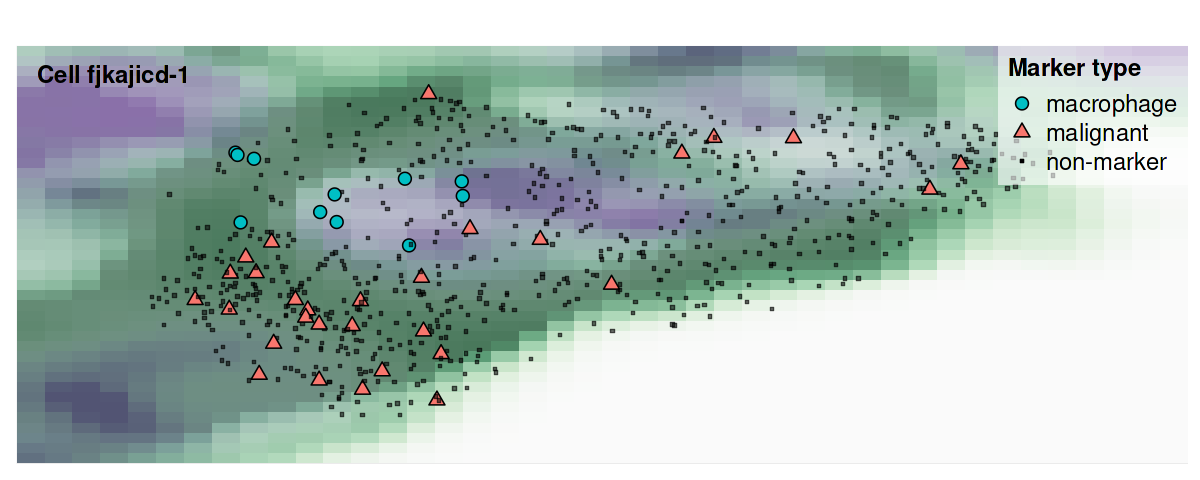

In [23]:
gg_cells[[1]]

In [24]:
tv <- seq(0, 1, 0.01)
leg_gg_base <- ggplot(data.frame(x=tv)) + geom_point(aes(x=x, y=x, color=x)) +
  cp_theme +
  guides(color=guide_colorbar(direction = "horizontal", title.position = "top", barwidth = 11, barheight = 0.75))

lgg1 <- leg_gg_base + scale_color_distiller(palette="Greens", direction=1, name="Membrane")
lgg2 <- leg_gg_base + scale_color_distiller(palette="Purples", direction=1, name="DAPI")

tlg <- guide_legend(direction="horizontal", title.position="top", title="Marker type")
lgg0 <- gg_cells[[1]] + guides(fill=tlg, shape=tlg, size=tlg)

gg_cells2 <- gg_cells %>% lapply(rasterise, layers="Tile") %>% lapply(`+`, theme(legend.position="none")) %>% {plot_grid(plotlist=., nrow=1)}
legends <- lapply(list(lgg0, lgg1, lgg2),function(x) {
  legend <- get_plot_component(x, 'guide-box-inside', return_all = TRUE)
  return(legend)
})
legends <- plot_grid(plotlist=legends, nrow=1)

fig2 <- plot_grid(plotlist=list(gg_cells2,legends), nrow=2, rel_heights=c(4.5, 0.75))

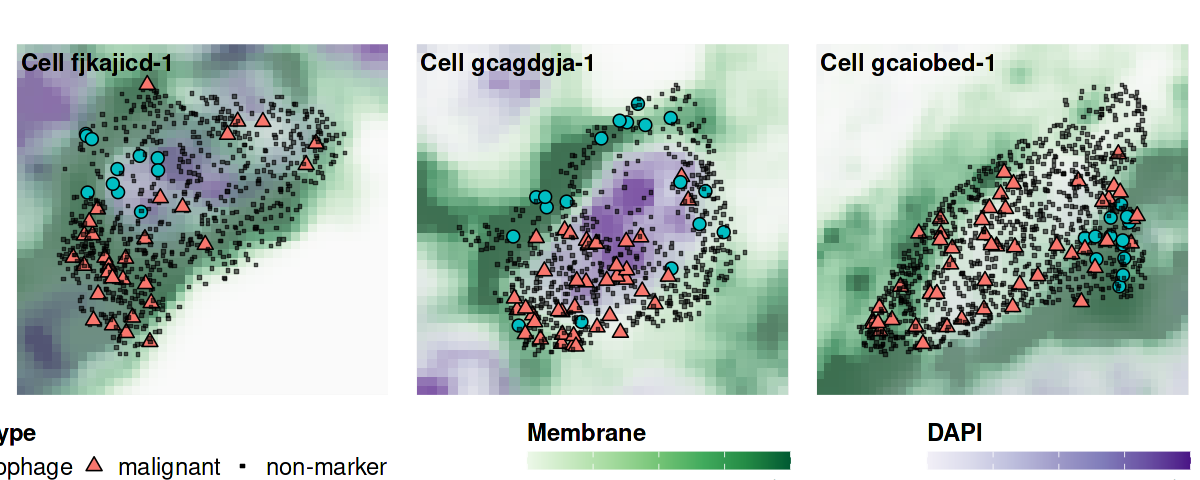

In [25]:
options(repr.plot.width=10, repr.plot.height=4)
fig2

In [26]:
pdf(OutputPath('oc_example_cells.pdf'), useDingbats=FALSE, width=10, height=4)
fig2
dev.off()

png 
  2